### Clustering and Topic Modeling Documents

In [0]:
!pip install -U -q gensim 
!pip install -U -q mpld3
!pip install -U -q pyldavis
!pip install -U -q beautifulsoup4

In [0]:
import re
import os
import codecs
import string
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as mcolors
import seaborn as sns

import nltk
from nltk.stem.wordnet import WordNetLemmatizer
#from nltk.tokenize import word_tokenize
from nltk.tokenize.casual import casual_tokenize
from nltk.tag import pos_tag

from bs4 import BeautifulSoup
from sklearn import feature_extraction
import mpld3

import gensim
import pyLDAvis
import pyLDAvis.gensim_models

from IPython.display import display, Image
from IPython.core.interactiveshell import InteractiveShell

%matplotlib inline

/databricks/python_shell/dbruntime/PythonPackageImportsInstrumentation/__init__.py:171: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  original_result = python_builtin_import(name, globals, locals, fromlist, level)


##### Disabling MLFlow autologging

In [0]:
import mlflow
mlflow.autolog(disable=True)

### Clustering and Topic Modeling applied to film synopses

In this guide, I will explain how to cluster a set of documents using Python. My motivating example is to identify the latent structures within the synopses of the top 100 films of all time (per an IMDB list). 

It will cover:

+ tokenizing and stemming each synopsis
+ transforming the corpus into vector space using [tf-idf](http://en.wikipedia.org/wiki/Tf%E2%80%93idf)
+ calculating cosine distance between each document as a measure of similarity
+ clustering the documents using the [k-means algorithm](http://en.wikipedia.org/wiki/K-means_clustering)
+ using [multidimensional scaling](http://en.wikipedia.org/wiki/Multidimensional_scaling) to reduce dimensionality within the corpus
+ plotting the clustering output using [matplotlib](http://matplotlib.org/) and [mpld3](http://mpld3.github.io/)
+ conducting a hierarchical clustering on the corpus using [Ward clustering](http://en.wikipedia.org/wiki/Ward%27s_method)
+ plotting a Ward dendrogram
+ topic modeling using [Latent Dirichlet Allocation (LDA)](http://en.wikipedia.org/wiki/Latent_Dirichlet_allocation)

#### 1 - Contents

[Stopwords, stemming, and tokenization](#Stopwords,-stemming,-and-tokenizing)  
[Tf-idf and document similarity](#Tf-idf-and-document-similarity)  
[K-means clustering](#K-means-clustering)  
[Multidimensional scaling](#Multidimensional-scaling)  
[Visualizing document clusters](#Visualizing-document-clusters)  
[Hierarchical document clustering](#Hierarchical-document-clustering)  
[Latent Dirichlet Allocation (LDA)](#Latent-Dirichlet-Allocation)

#### 1.1 - import three lists: titles, links and wikipedia synopses

In [0]:
titles = open(os.path.join('data', 'imdb', 'title_list.txt')).read().split('\n')
titles = titles[:100]  #ensures that only the first 100 are read in
print(str(len(titles)) + ' titles')
print(titles[0:5])

100 titles
['The Godfather', 'The Shawshank Redemption', "Schindler's List", 'Raging Bull', 'Casablanca']


In [0]:
links = open(os.path.join('data', 'imdb', 'link_list_imdb.txt')).read().split('\n')
links = links[:100]
print(str(len(links)) + ' links')

print(links[0:5])

100 links
['http://www.imdb.com/title/tt0068646/', 'http://www.imdb.com/title/tt0111161/', 'http://www.imdb.com/title/tt0108052/', 'http://www.imdb.com/title/tt0081398/', 'http://www.imdb.com/title/tt0034583/']


In [0]:
synopses_wiki = open(os.path.join('data', 'imdb', 'synopses_list_wiki.txt'), encoding="utf8").read().split('\n BREAKS HERE')
synopses_wiki = synopses_wiki[:100]

synopses_clean_wiki = []
for text in synopses_wiki:
    text = BeautifulSoup(text, 'html.parser').getText()
    #strips html formatting and converts to unicode
    synopses_clean_wiki.append(text)
synopses_wiki = synopses_clean_wiki

print(str(len(synopses_wiki)) + ' synopses')

print(synopses_wiki[0][0:627])

100 synopses
 Plot  [edit]  [  [  edit  edit  ]  ]  
  On the day of his only daughter's wedding, Vito Corleone hears requests in his role as the Godfather, the Don of a New York crime family. Vito's youngest son, Michael, in a Marine Corps uniform, introduces his girlfriend, Kay Adams, to his family at the sprawling reception. Vito's godson Johnny Fontane, a popular singer, pleads for help in securing a coveted movie role, so Vito dispatches his consigliere, Tom Hagen, to Los Angeles to influence the abrasive studio head, Jack Woltz. Woltz is unmoved until the morning he wakes up in bed with the severed head of his prized stallion.


In [0]:
synopses_imdb = open(os.path.join('data', 'imdb','synopses_list_imdb.txt'), encoding="utf8").read().split('\n BREAKS HERE')
synopses_imdb = synopses_imdb[:100]
synopses_clean_imdb = []

for text in synopses_imdb:
    text = BeautifulSoup(text, 'html.parser').getText()
    #strips html formatting and converts to unicode
    synopses_clean_imdb.append(text)

synopses_imdb = synopses_clean_imdb

print(str(len(synopses_imdb)) + ' synopses')

print(synopses_imdb[0][0:627])

100 synopses


In late summer 1945, guests are gathered for the wedding reception of Don Vito Corleone's daughter Connie (Talia Shire) and Carlo Rizzi (Gianni Russo). Vito (Marlon Brando), the head of the Corleone Mafia family, is known to friends and associates as "Godfather." He and Tom Hagen (Robert Duvall), the Corleone family lawyer, are hearing requests for favors because, according to Italian tradition, "no Sicilian can refuse a request on his daughter's wedding day." One of the men who asks the Don for a favor is Amerigo Bonasera, a successful mortician and acquaintance of the Don, whose daughter was brutally beaten by two y


#### 1.2 - Joining the two synopses sources

In [0]:
synopses = []
for i in range(len(synopses_wiki)):
    item = synopses_wiki[i] + synopses_imdb[i]
    synopses.append(item)
    
synopses[0]

Out[8]: ' Plot  [edit]  [  [  edit  edit  ]  ]  \n  On the day of his only daughter\'s wedding, Vito Corleone hears requests in his role as the Godfather, the Don of a New York crime family. Vito\'s youngest son, Michael, in a Marine Corps uniform, introduces his girlfriend, Kay Adams, to his family at the sprawling reception. Vito\'s godson Johnny Fontane, a popular singer, pleads for help in securing a coveted movie role, so Vito dispatches his consigliere, Tom Hagen, to Los Angeles to influence the abrasive studio head, Jack Woltz. Woltz is unmoved until the morning he wakes up in bed with the severed head of his prized stallion.  On the day of his only daughter\'s wedding,   Vito Corleone  Vito Corleone   hears requests in his role as the Godfather, the   Don  Don   of a New York crime family. Vito\'s youngest son,   Michael  Michael  , in a   Marine Corps  Marine Corps   uniform, introduces his girlfriend,   Kay Adams  Kay Adams  , to his family at the sprawling reception. Vito\'s

#### 1.3 - Importing the genres

In [0]:
genres = open(os.path.join('data', 'imdb','genres_list.txt')).read().split('\n')
genres = genres[:100]
print(str(len(genres)) + ' genres')

print(genres[0:5])

100 genres
["[u' Crime', u' Drama']", "[u' Crime', u' Drama']", "[u' Biography', u' Drama', u' History']", "[u' Biography', u' Drama', u' Sport']", "[u' Drama', u' Romance', u' War']"]


Generating index for each item in the corpora (in this case it's just rank)  
It will be used for scoring later

In [0]:
ranks = []

for i in range(0,len(titles)):
    ranks.append(i)

#### 1.3 - Stopwords, stemming, and tokenizing

This section is focused on defining some functions to manipulate the synopses.  
First, we load [NLTK's](http://www.nltk.org/) list of English stop words.  
[Stop words](http://en.wikipedia.org/wiki/Stop_words) are words like "a", "the", or "in" which don't convey significant meaning.

In [0]:
# load nltk's English stopwords as variable called 'stopwords'
# stopwords = nltk.corpus.stopwords.words('english')

We can also use our own list of stopwords

In [0]:
stopwords = [
"0o", "0s", "3a", "3b", "3d", "6b", "6o", "a", "a1", "a2", "a3", "a4", "ab", "able", "about", "above", "abst", "ac", "accordance", "according", "accordingly", "across", "act", "actually", "ad", "added", "adj", "ae", "af", "affected", "affecting", "affects", "after", "afterwards", "ag", "again", "against", "ah", "ain", "ain't", "aj", "al", "all", "allow", "allows", "almost", "alone", "along", "already", "also", "although", "always", "am", "among", "amongst", "amoungst", "amount", "an", "and", "announce", "another", "any", "anybody", "anyhow", "anymore", "anyone", "anything", "anyway", "anyways", "anywhere", "ao", "ap", "apart", "apparently", "appear", "appreciate", "appropriate", "approximately", "ar", "are", "aren", "arent", "aren't", "arise", "around", "as", "a's", "aside", "ask", "asking", "associated", "at", "au", "auth", "av", "available", "aw", "away", "awfully", "ax", "ay", "az", "b", "b1", "b2", "b3", "ba", "back", "bc", "bd", "be", "became", "because", "become", "becomes", "becoming", "been", "before", "beforehand", "begin", "beginning", "beginnings", "begins", "behind", "being", "believe", "below", "beside", "besides", "best", "better", "between", "beyond", "bi", "bill", "biol", "bj", "bk", "bl", "bn", "both", "bottom", "bp", "br", "brief", "briefly", "bs", "bt", "bu", "but", "bx", "by", "c", "c1", "c2", "c3", "ca", "call", "came", "can", "cannot", "cant", "can't", "cause", "causes", "cc", "cd", "ce", "certain", "certainly", "cf", "cg", "ch", "changes", "ci", "cit", "cj", "cl", "clearly", "cm", "c'mon", "cn", "co", "com", "come", "comes", "con", "concerning", "consequently", "consider", "considering", "contain", "containing", "contains", "corresponding", "could", "couldn", "couldnt", "couldn't", "course", "cp", "cq", "cr", "cry", "cs", "c's", "ct", "cu", "currently", "cv", "cx", "cy", "cz", "d", "d2", "da", "date", "dc", "dd", "de", "definitely", "describe", "described", "despite", "detail", "df", "di", "did", "didn", "didn't", "different", "dj", "dk", "dl", "do", "does", "doesn", "doesn't", "doing", "don", "done", "don't", "down", "downwards", "dp", "dr", "ds", "dt", "du", "due", "during", "dx", "dy", "e", "e2", "e3", "ea", "each", "ec", "ed", "edu", "ee", "ef", "effect", "eg", "ei", "eight", "eighty", "either", "ej", "el", "eleven", "else", "elsewhere", "em", "empty", "en", "end", "ending", "enough", "entirely", "eo", "ep", "eq", "er", "es", "especially", "est", "et", "et-al", "etc", "eu", "ev", "even", "ever", "every", "everybody", "everyone", "everything", "everywhere", "ex", "exactly", "example", "except", "ey", "f", "f2", "fa", "far", "fc", "few", "ff", "fi", "fifteen", "fifth", "fify", "fill", "find", "fire", "first", "five", "fix", "fj", "fl", "fn", "fo", "followed", "following", "follows", "for", "former", "formerly", "forth", "forty", "found", "four", "fr", "from", "front", "fs", "ft", "fu", "full", "further", "furthermore", "fy", "g", "ga", "gave", "ge", "get", "gets", "getting", "gi", "give", "given", "gives", "giving", "gj", "gl", "go", "goes", "going", "gone", "got", "gotten", "gr", "greetings", "gs", "gy", "h", "h2", "h3", "had", "hadn", "hadn't", "happens", "hardly", "has", "hasn", "hasnt", "hasn't", "have", "haven", "haven't", "having", "he", "hed", "he'd", "he'll", "hello", "help", "hence", "her", "here", "hereafter", "hereby", "herein", "heres", "here's", "hereupon", "hers", "herself", "hes", "he's", "hh", "hi", "hid", "him", "himself", "his", "hither", "hj", "ho", "home", "hopefully", "how", "howbeit", "however", "how's", "hr", "hs", "http", "hu", "hundred", "hy", "i", "i2", "i3", "i4", "i6", "i7", "i8", "ia", "ib", "ibid", "ic", "id", "i'd", "ie", "if", "ig", "ignored", "ih", "ii", "ij", "il", "i'll", "im", "i'm", "immediate", "immediately", "importance", "important", "in", "inasmuch", "inc", "indeed", "index", "indicate", "indicated", "indicates", "information", "inner", "insofar", "instead", "interest", "into", "invention", "inward", "io", "ip", "iq", "ir", "is", "isn", "isn't", "it", "itd", "it'd", "it'll", "its", "it's", "itself", "iv", "i've", "ix", "iy", "iz", "j", "jj", "jr", "js", "jt", "ju", "just", "k", "ke", "keep", "keeps", "kept", "kg", "kj", "km", "know", "known", "knows", "ko", "l", "l2", "la", "largely", "last", "lately", "later", "latter", "latterly", "lb", "lc", "le", "least", "les", "less", "lest", "let", "lets", "let's", "lf", "like", "liked", "likely", "line", "little", "lj", "ll", "ll", "ln", "lo", "look", "looking", "looks", "los", "lr", "ls", "lt", "ltd", "m", "m2", "ma", "made", "mainly", "make", "makes", "many", "may", "maybe", "me", "mean", "means", "meantime", "meanwhile", "merely", "mg", "might", "mightn", "mightn't", "mill", "million", "mine", "miss", "ml", "mn", "mo", "more", "moreover", "most", "mostly", "move", "mr", "mrs", "ms", "mt", "mu", "much", "mug", "must", "mustn", "mustn't", "my", "myself", "n", "n2", "na", "name", "namely", "nay", "nc", "nd", "ne", "near", "nearly", "necessarily", "necessary", "need", "needn", "needn't", "needs", "neither", "never", "nevertheless", "new", "next", "ng", "ni", "nine", "ninety", "nj", "nl", "nn", "no", "nobody", "non", "none", "nonetheless", "noone", "nor", "normally", "nos", "not", "noted", "nothing", "novel", "now", "nowhere", "nr", "ns", "nt", "ny", "o", "oa", "ob", "obtain", "obtained", "obviously", "oc", "od", "of", "off", "often", "og", "oh", "oi", "oj", "ok", "okay", "ol", "old", "om", "omitted", "on", "once", "one", "ones", "only", "onto", "oo", "op", "oq", "or", "ord", "os", "ot", "other", "others", "otherwise", "ou", "ought", "our", "ours", "ourselves", "out", "outside", "over", "overall", "ow", "owing", "own", "ox", "oz", "p", "p1", "p2", "p3", "page", "pagecount", "pages", "par", "part", "particular", "particularly", "pas", "past", "pc", "pd", "pe", "per", "perhaps", "pf", "ph", "pi", "pj", "pk", "pl", "placed", "please", "plus", "pm", "pn", "po", "poorly", "possible", "possibly", "potentially", "pp", "pq", "pr", "predominantly", "present", "presumably", "previously", "primarily", "probably", "promptly", "proud", "provides", "ps", "pt", "pu", "put", "py", "q", "qj", "qu", "que", "quickly", "quite", "qv", "r", "r2", "ra", "ran", "rather", "rc", "rd", "re", "readily", "really", "reasonably", "recent", "recently", "ref", "refs", "regarding", "regardless", "regards", "related", "relatively", "research", "research-articl", "respectively", "resulted", "resulting", "results", "rf", "rh", "ri", "right", "rj", "rl", "rm", "rn", "ro", "rq", "rr", "rs", "rt", "ru", "run", "rv", "ry", "s", "s2", "sa", "said", "same", "saw", "say", "saying", "says", "sc", "sd", "se", "sec", "second", "secondly", "section", "see", "seeing", "seem", "seemed", "seeming", "seems", "seen", "self", "selves", "sensible", "sent", "serious", "seriously", "seven", "several", "sf", "shall", "shan", "shan't", "she", "shed", "she'd", "she'll", "shes", "she's", "should", "shouldn", "shouldn't", "should've", "show", "showed", "shown", "showns", "shows", "si", "side", "significant", "significantly", "similar", "similarly", "since", "sincere", "six", "sixty", "sj", "sl", "slightly", "sm", "sn", "so", "some", "somebody", "somehow", "someone", "somethan", "something", "sometime", "sometimes", "somewhat", "somewhere", "soon", "sorry", "sp", "specifically", "specified", "specify", "specifying", "sq", "sr", "ss", "st", "still", "stop", "strongly", "sub", "substantially", "successfully", "such", "sufficiently", "suggest", "sup", "sure", "sy", "system", "sz", "t", "t1", "t2", "t3", "take", "taken", "taking", "tb", "tc", "td", "te", "tell", "ten", "tends", "tf", "th", "than", "thank", "thanks", "thanx", "that", "that'll", "thats", "that's", "that've", "the", "their", "theirs", "them", "themselves", "then", "thence", "there", "thereafter", "thereby", "thered", "therefore", "therein", "there'll", "thereof", "therere", "theres", "there's", "thereto", "thereupon", "there've", "these", "they", "theyd", "they'd", "they'll", "theyre", "they're", "they've", "thickv", "thin", "think", "third", "this", "thorough", "thoroughly", "those", "thou", "though", "thoughh", "thousand", "three", "throug", "through", "throughout", "thru", "thus", "ti", "til", "tip", "tj", "tl", "tm", "tn", "to", "together", "too", "took", "top", "toward", "towards", "tp", "tq", "tr", "tried", "tries", "truly", "try", "trying", "ts", "t's", "tt", "tv", "twelve", "twenty", "twice", "two", "tx", "u", "u201d", "ue", "ui", "uj", "uk", "um", "un", "under", "unfortunately", "unless", "unlike", "unlikely", "until", "unto", "uo", "up", "upon", "ups", "ur", "us", "use", "used", "useful", "usefully", "usefulness", "uses", "using", "usually", "ut", "v", "va", "value", "various", "vd", "ve", "ve", "very", "via", "viz", "vj", "vo", "vol", "vols", "volumtype", "vq", "vs", "vt", "vu", "w", "wa", "want", "wants", "was", "wasn", "wasnt", "wasn't", "way", "we", "wed", "we'd", "welcome", "well", "we'll", "well-b", "went", "were", "we're", "weren", "werent", "weren't", "we've", "what", "whatever", "what'll", "whats", "what's", "when", "whence", "whenever", "when's", "where", "whereafter", "whereas", "whereby", "wherein", "wheres", "where's", "whereupon", "wherever", "whether", "which", "while", "whim", "whither", "who", "whod", "whoever", "whole", "who'll", "whom", "whomever", "whos", "who's", "whose", "why", "why's", "wi", "widely", "will", "willing", "wish", "with", "within", "without", "wo", "won", "wonder", "wont", "won't", "words", "world", "would", "wouldn", "wouldnt", "wouldn't", "www", "x", "x1", "x2", "x3", "xf", "xi", "xj", "xk", "xl", "xn", "xo", "xs", "xt", "xv", "xx", "y", "y2", "yes", "yet", "yj", "yl", "you", "youd", "you'd", "you'll", "your", "youre", "you're", "yours", "yourself", "yourselves", "you've", "yr", "ys", "yt", "z", "zero", "zi", "zz",
]

Next we import the [Snowball Stemmer](http://snowball.tartarus.org/) which is actually part of NLTK.  
[Stemming](http://en.wikipedia.org/wiki/Stemming) is just the process of breaking a word down into its root.

In [0]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

Below we define two functions:

+ *tokenize_and_stem*: tokenizes (splits the synopsis into a list of its respective words (or tokens) and also stems each token
+ *tokenize_only*: tokenizes the synopsis only

I use both these functions to create a dictionary which becomes important in case I want to use stems for an algorithm, but later convert stems back to their full words for presentation purposes. Guess what, I do want to do that!

In [0]:
def tokenize_and_stem(text):
    tokens = [word for word in casual_tokenize(text)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    tokens = [word.lower() for word in casual_tokenize(text)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

Below we use my stemming/tokenizing and tokenizing functions to iterate over the list of synopses to create two vocabularies: one stemmed and one only tokenized.

In [0]:
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in synopses:
    allwords_stemmed = tokenize_and_stem(i)
    totalvocab_stemmed.extend(allwords_stemmed)
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

Using these two lists, we create a pandas DataFrame with the stemmed vocabulary as the index and the tokenized words as the column.  
The benefit of this is it provides an efficient way to look up a stem and return a full token.  

The downside here is that stems to tokens are one to many: the stem 'run' could be associated with 'ran', 'runs', 'running', etc.  
For our purposes this is fine -- We are perfectly happy returning the first token associated with the stem we need to look up.

In [0]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
vocab_frame.drop_duplicates(inplace=True)
vocab_frame.head(10)

,words
plot,plot
edit,edit
on,on
the,the
day,day
of,of
his,his
onli,only
daughter,daughter's
wed,wedding


#### 1.4 - Tf-idf and document similarity

<img src='http://www.jiem.org/index.php/jiem/article/viewFile/293/252/2402' align='right' style="margin-left:10px">

Here, we define term frequency-inverse document frequency (tf-idf) vectorizer parameters and then convert the *synopses* list into a tf-idf matrix. 

To get a Tf-idf matrix, first count word occurrences by document. This is transformed into a document-term matrix (dtm). This is also just called a term frequency matrix.

Then apply the term frequency-inverse document frequency weighting: words that occur frequently within a document but not frequently within the corpus receive a higher weighting as these words are assumed to contain more meaning in relation to the document.

A couple things to note about the parameters we define below:


+ max_df: this is the maximum frequency within the documents a given feature can have to be used in the tfi-idf matrix. If the term is in greater than 80% of the documents it probably cares little meanining (in the context of film synopses)
+ min_idf: this could be an integer (e.g. 5) and the term would have to be in at least 5 of the documents to be considered. Here I pass 0.2; the term must be in at least 20% of the document. I found that if I allowed a lower min_df I ended up basing clustering on names--for example "Michael" or "Tom" are names found in several of the movies and the synopses use these names frequently, but the names carry no real meaning.
+ ngram_range: this just means I'll look at unigrams, bigrams and ~~trigrams~~. See [n-grams](http://en.wikipedia.org/wiki/N-gram)

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_df=0.9, 
                                   max_features=2000,
                                   min_df=0.1, 
                                   stop_words='english',   #change to your own list if needed
                                   use_idf=True, 
                                   tokenizer=tokenize_and_stem, 
                                   ngram_range=(1,2))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(synopses)

print(tfidf_matrix.shape)

/databricks/python/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
CPU times: user 4.8

In [0]:
terms = tfidf_vectorizer.get_feature_names()

Out[19]: <AxesSubplot:>

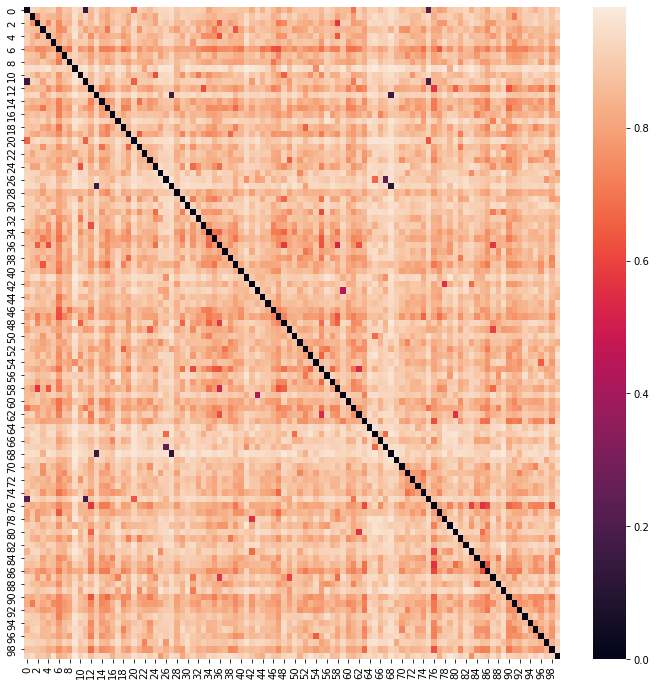

In [0]:
from sklearn.metrics.pairwise import cosine_similarity

dist = 1 - cosine_similarity(tfidf_matrix)

plt.figure(figsize=(18,18))
sns.heatmap(dist)

#### 1.5 - K-means clustering

Using the tf-idf matrix, we can run a slew of clustering algorithms to better understand the hidden structure within the synopses. 
We first chose [k-means](http://en.wikipedia.org/wiki/K-means_clustering). K-means initializes with a pre-determined number of clusters.  

Each observation is assigned to a cluster (cluster assignment) so as to minimize the within cluster sum of squares. Next, the mean of the clustered observations is calculated and used as the new cluster centroid. Then, observations are reassigned to clusters and  centroids recalculated in an iterative process until the algorithm reaches convergence.  

We found it took several runs for the algorithm to converge a global optimum as k-means is susceptible to reaching local optima.

In [0]:
from sklearn.cluster import KMeans

num_clusters = 5
km = KMeans(n_clusters=num_clusters)
km.fit(tfidf_matrix)
clusters = km.labels_.tolist()

CPU times: user 91.7 ms, sys: 4.26 ms, total: 95.9 ms
Wall time: 109 ms


In [0]:
films = {'title': titles, 'rank': ranks, 'synopsis': synopses, 'cluster': clusters, 'genre': genres}
frame = pd.DataFrame(films, index = [ranks] , columns = ['rank', 'cluster','title' , 'genre'])
frame.head(10)

,rank,cluster,title,genre
0,0,3,The Godfather,"[u' Crime', u' Drama']"
1,1,2,The Shawshank Redemption,"[u' Crime', u' Drama']"
2,2,1,Schindler's List,"[u' Biography', u' Drama', u' History']"
3,3,4,Raging Bull,"[u' Biography', u' Drama', u' Sport']"
4,4,1,Casablanca,"[u' Drama', u' Romance', u' War']"
5,5,2,One Flew Over the Cuckoo's Nest,[u' Drama']
6,6,0,Gone with the Wind,"[u' Drama', u' Romance', u' War']"
7,7,0,Citizen Kane,"[u' Drama', u' Mystery']"
8,8,0,The Wizard of Oz,"[u' Adventure', u' Family', u' Fantasy', u' Mu..."
9,9,2,Titanic,"[u' Drama', u' Romance']"


In [0]:
pd.DataFrame(frame['cluster'].value_counts()).sort_index()

,cluster
0,20
1,23
2,44
3,8
4,5


In [0]:
grouped = frame['rank'].groupby(frame['cluster'])
grouped.mean()

Out[23]: cluster
0    44.900000
1    50.652174
2    55.500000
3    38.625000
4    27.200000
Name: rank, dtype: float64

In [0]:
print("Top terms per cluster:")
print()
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(num_clusters):
    print(f"Cluster {i} words:", end='')
    for ind in order_centroids[i, :6]:
        print(f" {vocab_frame.loc[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore')}", end=',')
    print("\n")
    print(f"Cluster {i} titles:", end='')
    for title in frame.loc[i]['title'].values.tolist():
        print(f' {title},', end='')
    print("\n\n")

Top terms per cluster:

Cluster 0 words: b'family', b'henry', b'war', b'love', b'home', b'returns',

Cluster 0 titles: The Godfather,


Cluster 1 words: b'germans', b'soldiers', b'army', b'killed', b'war', b'paul',

Cluster 1 titles: The Shawshank Redemption,


Cluster 2 words: b'police', b'car', b'father', b'killed', b'man', b'apartments',

Cluster 2 titles: Schindler's List,


Cluster 3 words: b'michael', b'george', b'e', b'boat', b'family', b'water',

Cluster 3 titles: Raging Bull,


Cluster 4 words: b'joe', b'film', b'brothers', b'singing', b'flashback', b'picture',

Cluster 4 titles: Casablanca,




This is purely to help export tables to html and to correct for my 0 start rank (so that Godfather is 1, not 0)

In [0]:
frame['Rank'] = frame['rank'] + 1
frame['Title'] = frame['title']

In [0]:
html_output = frame[['Rank', 'Title']].loc[frame['cluster'] == 1].to_html(index=False)

from IPython.core.display import display, HTML
display(HTML(html_output))

Rank,Title
3,Schindler's List
5,Casablanca
25,The Bridge on the River Kwai
30,Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb
32,Apocalypse Now
34,The Lord of the Rings: The Return of the King
35,Gladiator
36,From Here to Eternity
37,Saving Private Ryan
39,Raiders of the Lost Ark


#### 1.6 - Multidimensional scaling and Visualizing document clusters

It will be two components as we're plotting points in a two-dimensional plane.  
"Precomputed" because we provide a distance matrix  
We will also specify `random_state` so the plot is reproducible.

In [0]:
from sklearn.manifold import MDS

mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
pos = mds.fit_transform(dist)  # shape (n_components, n_samples)
xs, ys = pos[:, 0], pos[:, 1]

In [0]:
#strip any proper nouns (NNP) or plural proper nouns (NNPS) from a text
from nltk.tag import pos_tag

def strip_proppers_POS(text):
    tagged = pos_tag(text.split()) #use NLTK's part of speech tagger
    non_propernouns = [word for word,pos in tagged if pos != 'NNP' and pos != 'NNPS']
    return non_propernouns

In [0]:
#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}

#set up cluster names using a dict
cluster_names = {0: 'Family, home, war', 
                 1: 'Police, killed, murders', 
                 2: 'Father, New York, brothers', 
                 3: 'Dance, singing, love', 
                 4: 'Killed, soldiers, captain'}

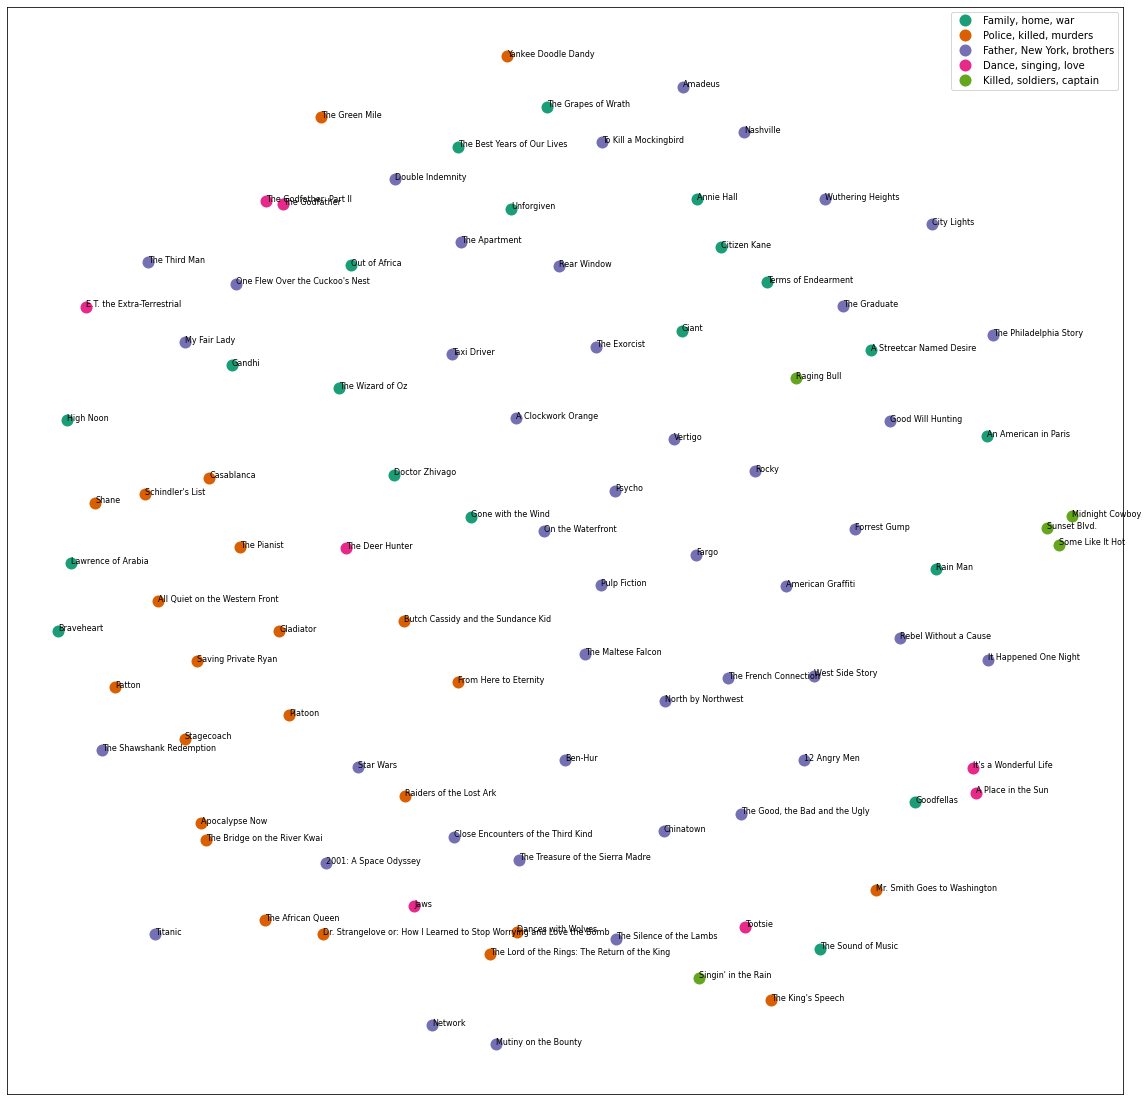

In [0]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(20, 20)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, label=cluster_names[name], color=cluster_colors[name], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False)
    
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelleft=False)
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.loc[i]['x'], df.loc[i]['y'], df.loc[i]['title'], size=8)  

plt.show()

The clustering plot looks great, but it would be better without overlapping labels. We are going to use D3.js (http://d3js.org/), a browser based/javascript interactive. We will use a matplotlib D3 wrapper called mpld3 (https://mpld3.github.io/). Mpld3 basically let's you use matplotlib syntax to create web interactives. It has a really easy, high-level API for adding tooltips on mouse hover, which is what I am interested in.

It also has some nice functionality for zooming and panning. The below javascript snippet basicaly defines a custom location for where the zoom/pan toggle resides. Don't worry about it too much and you actually don't need to use it, but it helped for formatting purposes when exporting to the web later. The only thing you might want to change is the x and y attr for the position of the toolbar.

In [0]:
#define custom toolbar location
class TopToolbar(mpld3.plugins.PluginBase):
    """Plugin for moving toolbar to top of figure"""

    JAVASCRIPT = """
    mpld3.register_plugin("toptoolbar", TopToolbar);
    TopToolbar.prototype = Object.create(mpld3.Plugin.prototype);
    TopToolbar.prototype.constructor = TopToolbar;
    function TopToolbar(fig, props){
        mpld3.Plugin.call(this, fig, props);
    };

    TopToolbar.prototype.draw = function(){
      // the toolbar svg doesn't exist
      // yet, so first draw it
      this.fig.toolbar.draw();

      // then change the y position to be
      // at the top of the figure
      this.fig.toolbar.toolbar.attr("x", 150);
      this.fig.toolbar.toolbar.attr("y", 400);

      // then remove the draw function,
      // so that it is not called again
      this.fig.toolbar.draw = function() {}
    }
    """
    def __init__(self):
        self.dict_ = {"type": "toptoolbar"}

In [0]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 

#group by cluster
groups = df.groupby('label')

#define custom css to format the font and to remove the axis labeling
css = """
text.mpld3-text, div.mpld3-tooltip {
  font-family:Arial, Helvetica, sans-serif;
}

g.mpld3-xaxis, g.mpld3-yaxis {
display: none; }
"""

# Plot 
fig, ax = plt.subplots(figsize=(14,6)) #set plot size
ax.margins(0.03) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    points = ax.plot(group.x, group.y, marker='o', linestyle='', ms=18, label=cluster_names[name], mec='none', color=cluster_colors[name])
    ax.set_aspect('auto')
    labels = [i for i in group.title]
    
    #set tooltip using points, labels and the already defined 'css'
    tooltip = mpld3.plugins.PointHTMLTooltip(points[0], labels,
                                       voffset=10, hoffset=10, css=css)
    #connect tooltip to fig
    mpld3.plugins.connect(fig, tooltip, TopToolbar())    
    
    #set tick marks as blank
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    
    #set axis as blank
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    
ax.legend(numpoints=1) #show legend with only one dot

mpld3.display() #show the plot

In [0]:
#uncomment the below to export to html
html_output = mpld3.fig_to_html(fig)
display(HTML(html_output))

#### 1.7 - Hierarchical document clustering

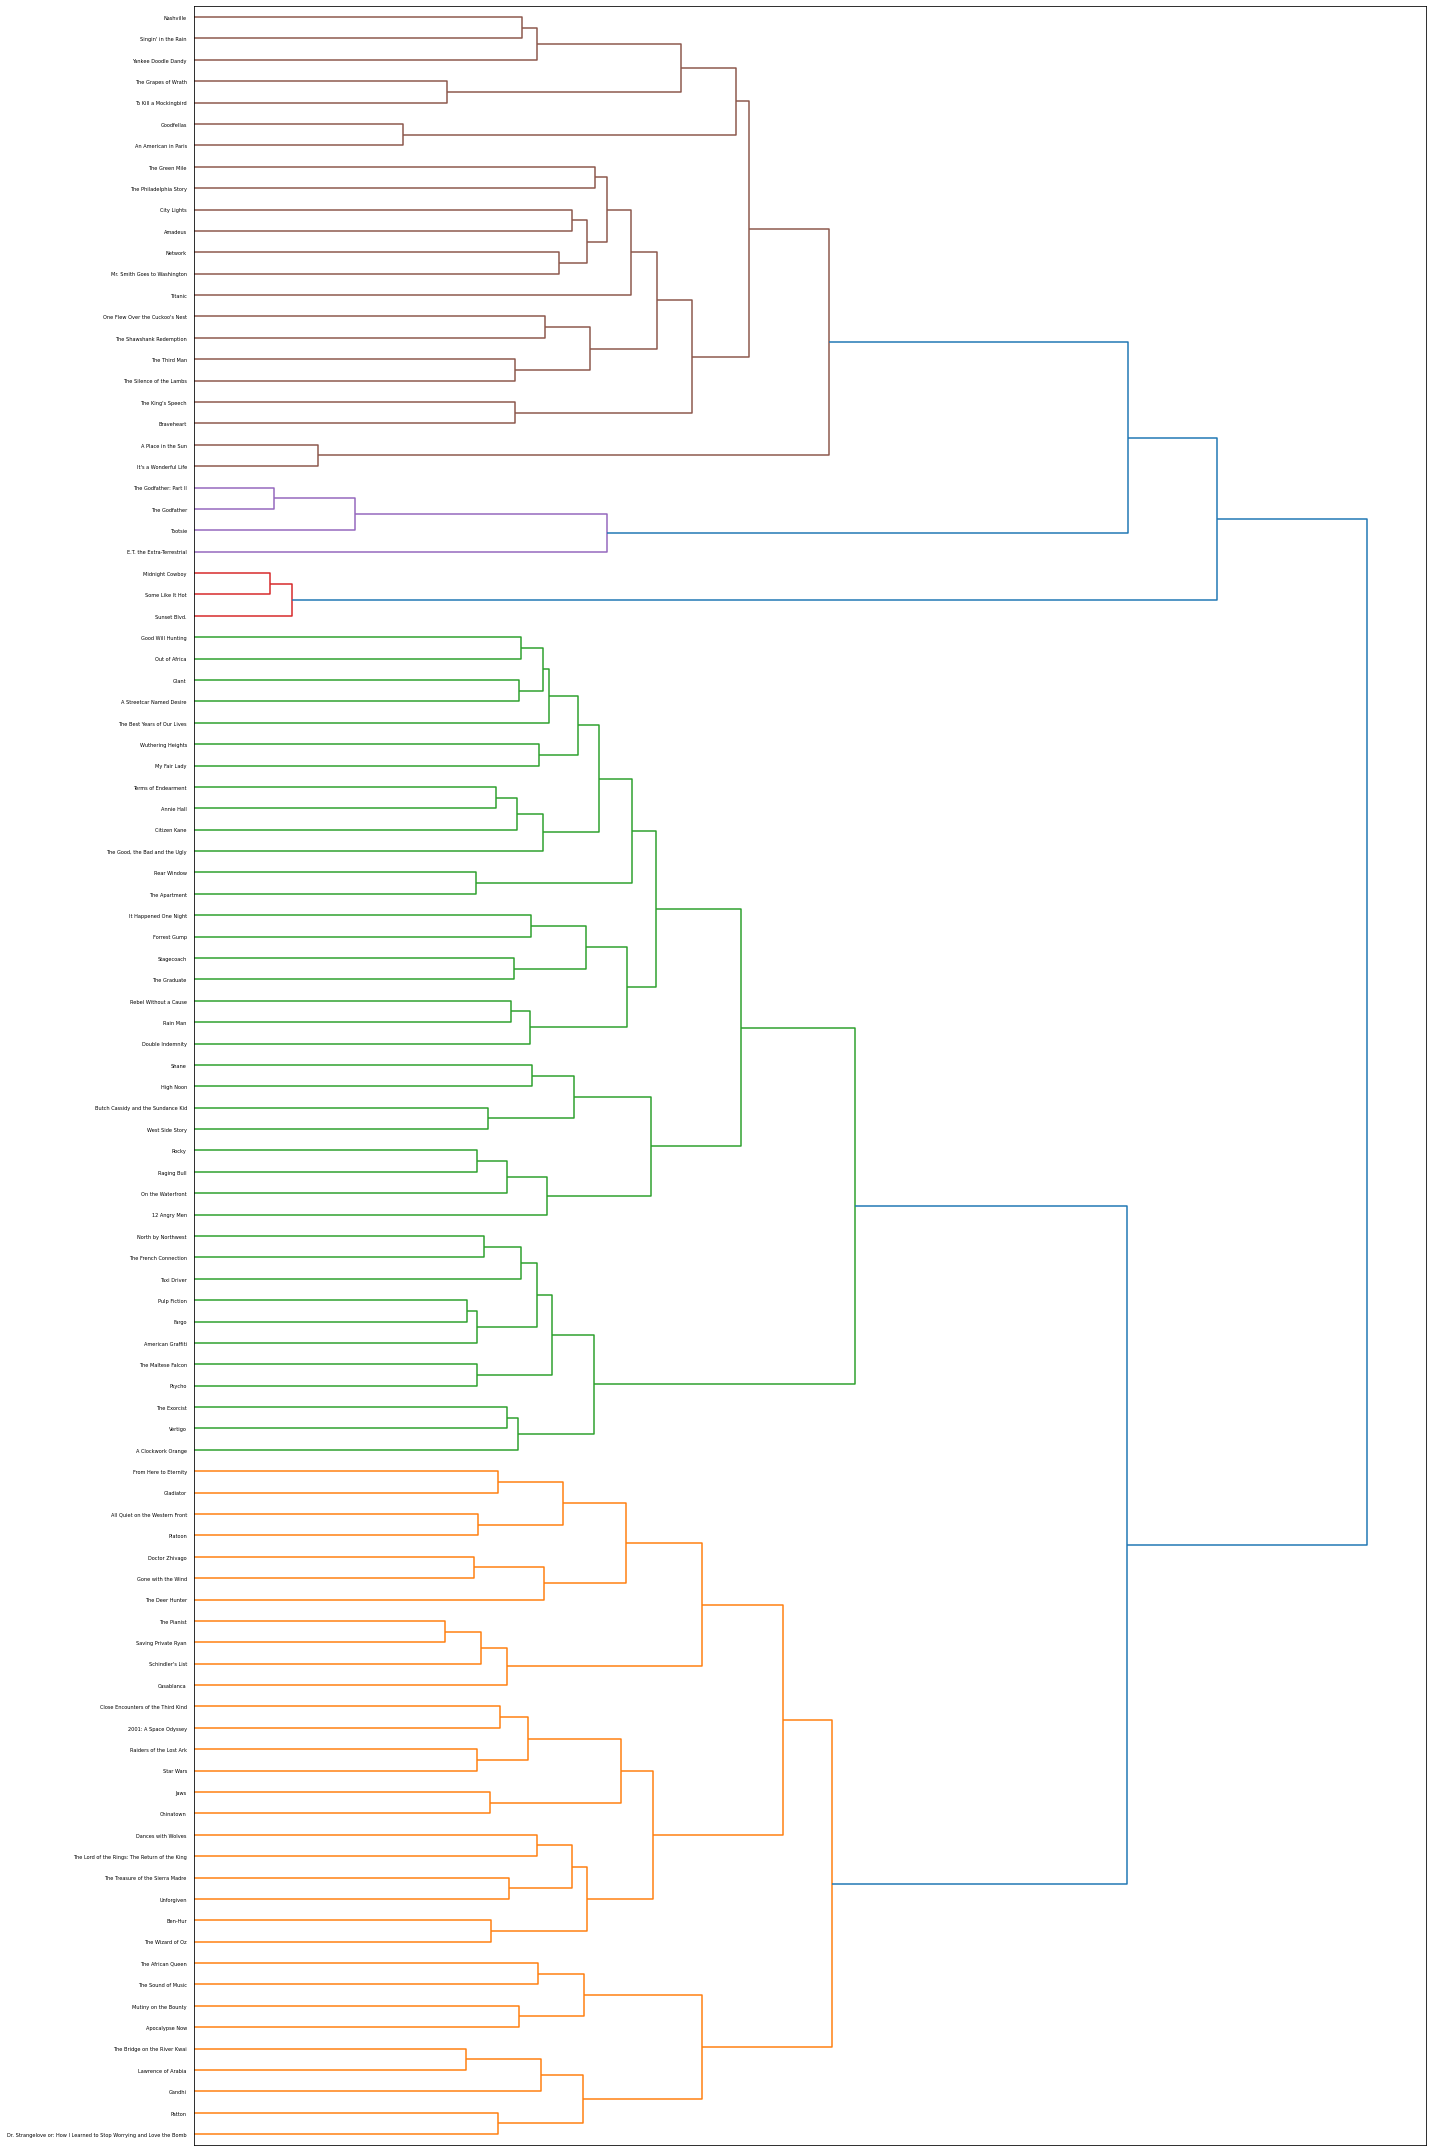

In [0]:
from scipy.cluster.hierarchy import ward, dendrogram

linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(20, 30))
ax = dendrogram(linkage_matrix, orientation="right", labels=titles);

plt.tick_params(axis= 'x',         # changes apply to the x-axis
                which='both',      # both major and minor ticks are affected
                bottom=False,      # ticks along the bottom edge are off
                top=False,         # ticks along the top edge are off
                labelbottom=False)

plt.tight_layout()
#plt.savefig(os.path.join('/', 'tmp','ward_clusters.png'), dpi=200)

#### 1.8 - Latent Dirichlet Allocation

In [0]:
def strip_proppers(text):
    tokens = [word for word in casual_tokenize(text) if word.islower()]
    return "".join([" "+i if not i.startswith("'") and i not in string.punctuation else i for i in tokens]).strip()

In [0]:
#strip any proper nouns (NNP) or plural proper nouns (NNPS) from a text
def strip_proppers_POS(text):
    tagged = pos_tag(text.split()) #use NLTK's part of speech tagger
    non_propernouns = [word for word, pos in tagged if pos != 'NNP' and pos != 'NNPS']
    return non_propernouns

In [0]:
#Latent Dirichlet Allocation implementation with Gensim
from gensim import corpora, models, similarities 

preprocess = [strip_proppers(doc) for doc in synopses]
tokenized_text = [tokenize_and_stem(text) for text in preprocess]
texts = [[word for word in text if word not in stopwords] for text in tokenized_text]

In [0]:
#print(len([word for word in texts[0] if word not in stopwords]))
print(len(texts[0]))

1491


In [0]:
dictionary = corpora.Dictionary(texts)
dictionary.filter_extremes(no_below=1, no_above=0.8)
corpus = [dictionary.doc2bow(text) for text in texts]
print(len(corpus))

100


In [0]:
lda = models.LdaModel(corpus, num_topics=6, id2word=dictionary, update_every=5, chunksize=10000, passes=100)

[(2, 0.71995777), (3, 0.27958065)]


In [0]:
for movie in range(100):
    print(f"Movie {titles[movie]} is compound by topics {lda[corpus[movie]]}")

Movie The Godfather is compound by topics [(2, 0.7199591), (3, 0.27957934)]
Movie The Shawshank Redemption is compound by topics [(1, 0.9993929)]
Movie Schindler's List is compound by topics [(3, 0.9991181)]
Movie Raging Bull is compound by topics [(3, 0.99896157)]
Movie Casablanca is compound by topics [(3, 0.99884325)]
Movie One Flew Over the Cuckoo's Nest is compound by topics [(1, 0.83109933), (2, 0.16831705)]
Movie Gone with the Wind is compound by topics [(2, 0.11505918), (3, 0.7129687), (5, 0.17172547)]
Movie Citizen Kane is compound by topics [(4, 0.999075)]
Movie The Wizard of Oz is compound by topics [(2, 0.9989314)]
Movie Titanic is compound by topics [(5, 0.9987777)]
Movie Lawrence of Arabia is compound by topics [(3, 0.9990541)]
Movie The Godfather: Part II is compound by topics [(3, 0.99936473)]
Movie Psycho is compound by topics [(2, 0.6179604), (5, 0.38158256)]
Movie Sunset Blvd. is compound by topics [(2, 0.31891555), (5, 0.6802808)]
Movie Vertigo is compound by topics

In [0]:
#topics = lda.print_topics(5, num_words=20)
for topic in lda.show_topics():
    print(topic)

(0, '0.006*"love" + 0.005*"sing" + 0.005*"friend" + 0.004*"perform" + 0.004*"wife" + 0.004*"day" + 0.004*"famili" + 0.004*"final" + 0.004*"film" + 0.004*"becom"')
(1, '0.009*"shark" + 0.005*"friend" + 0.004*"fight" + 0.004*"vote" + 0.004*"prison" + 0.004*"day" + 0.004*"night" + 0.003*"boat" + 0.003*"guilti" + 0.003*"goe"')
(2, '0.008*"car" + 0.008*"polic" + 0.007*"meet" + 0.005*"kill" + 0.005*"day" + 0.005*"murder" + 0.005*"night" + 0.005*"arriv" + 0.004*"hous" + 0.004*"drive"')
(3, '0.010*"kill" + 0.007*"men" + 0.005*"order" + 0.005*"soldier" + 0.005*"famili" + 0.005*"brother" + 0.004*"friend" + 0.004*"arriv" + 0.004*"town" + 0.004*"shoot"')
(4, '0.005*"kill" + 0.005*"arriv" + 0.004*"fight" + 0.004*"life" + 0.004*"decid" + 0.004*"discov" + 0.004*"love" + 0.004*"friend" + 0.004*"boat" + 0.004*"meet"')
(5, '0.006*"kill" + 0.006*"famili" + 0.005*"night" + 0.004*"die" + 0.004*"son" + 0.004*"soldier" + 0.004*"arriv" + 0.004*"forc" + 0.004*"becom" + 0.004*"order"')


In [0]:
topics_matrix = lda.show_topics(formatted=False, num_words=20)
topics_matrix[0]

Out[42]: (0,
 [('love', 0.005618103),
  ('sing', 0.004954073),
  ('friend', 0.004703496),
  ('perform', 0.0043581543),
  ('wife', 0.0041177752),
  ('day', 0.0039123837),
  ('famili', 0.0038624562),
  ('final', 0.0038612701),
  ('film', 0.003795967),
  ('becom', 0.0036618987),
  ('anoth', 0.0036119516),
  ('children', 0.0033936908),
  ('record', 0.0033388822),
  ('mission', 0.0033320447),
  ('relationship', 0.0033165985),
  ('play', 0.0033095228),
  ('follow', 0.0031818675),
  ('year', 0.0031614916),
  ('night', 0.0031165732),
  ('mother', 0.003037134)])

In [0]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(lda, corpus, dictionary)

/local_disk0/.ephemeral_nfs/envs/pythonEnv-8cbe88fe-6ddb-4877-9bac-68c59823462e/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


#### Displaying the importance of words in each topic

<command-3466094929677481>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')


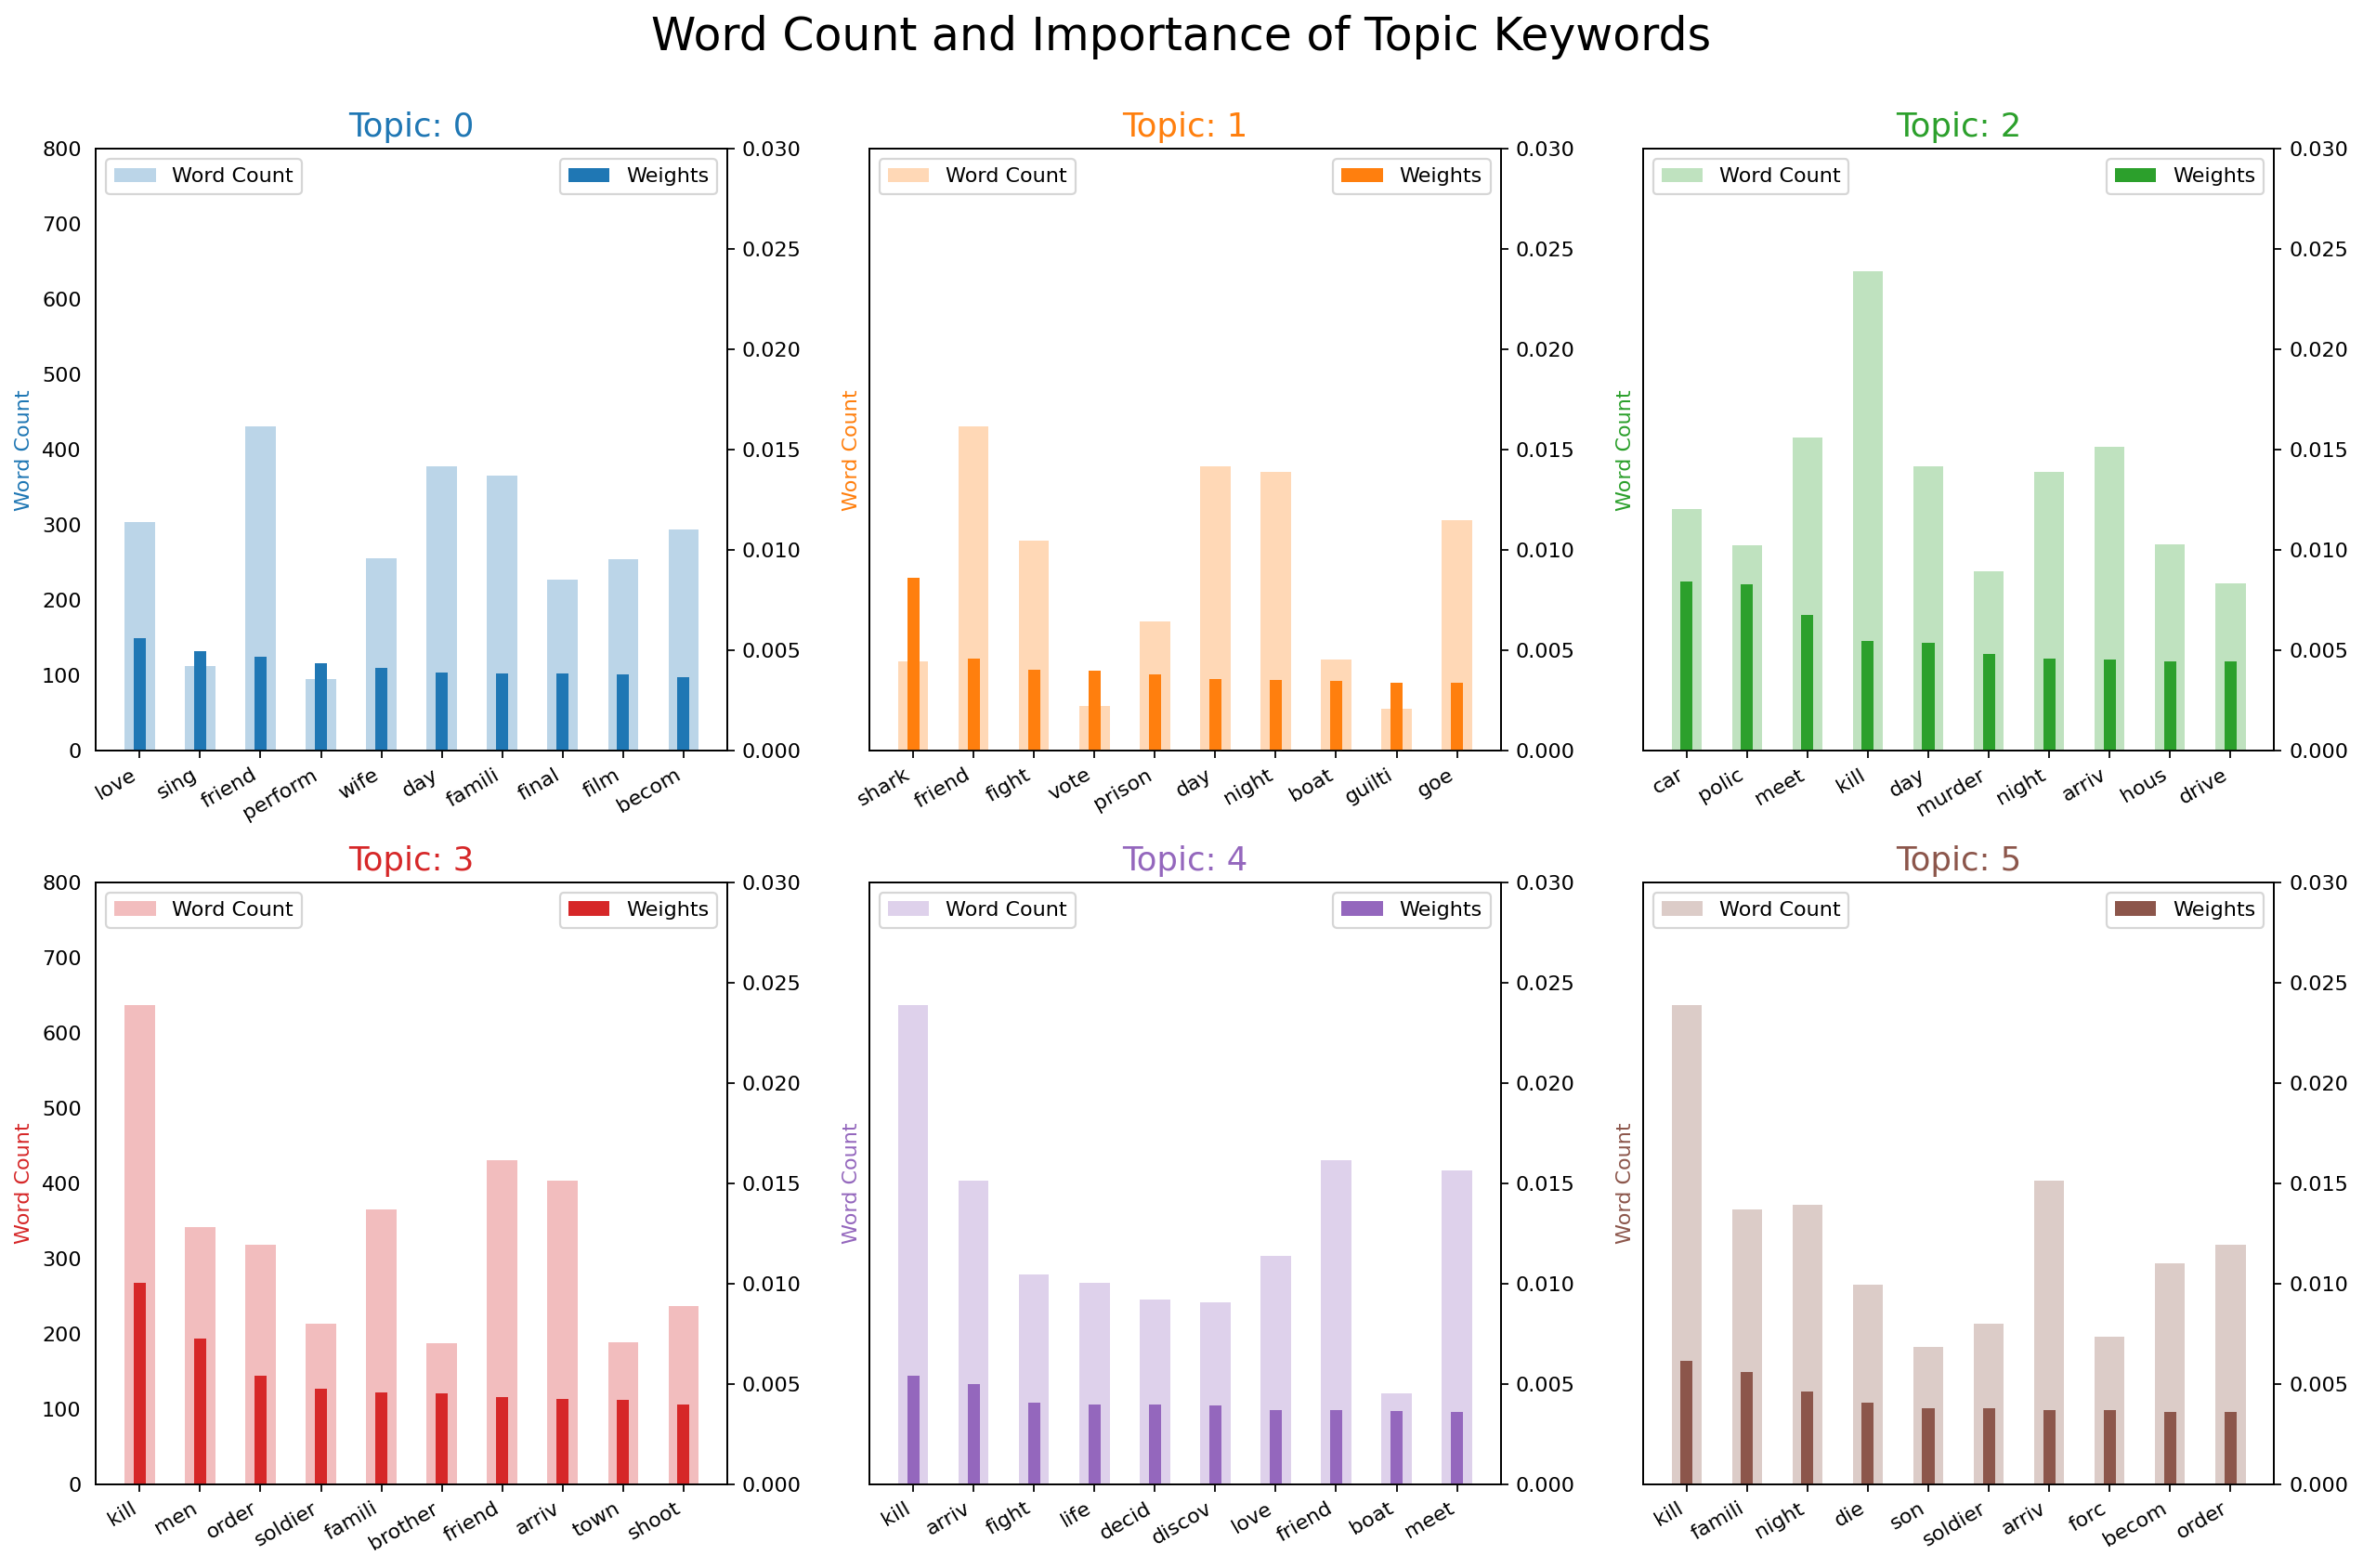

In [0]:
topics = lda.show_topics(formatted=False)
data_flat = [w for w_list in texts for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 3, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 800)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

#### What is the Dominant topic and its percentage contribution in each document

In [0]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), 
                                                                  round(prop_topic,4), 
                                                                  topic_keywords]), 
                                                       ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(lda, corpus, texts)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2.0,0.7200,"car, polic, meet, kill, day, murder, night, ar...","[edit, edit, edit, day, onli, daughter, hear, ..."
1,1,1.0,0.9994,"shark, friend, fight, vote, prison, day, night...","[edit, edit, edit, banker, convict, murder, wi..."
2,2,3.0,0.9991,"kill, men, order, soldier, famili, brother, fr...","[edit, edit, edit, ethnic, arriv, citi, hope, ..."
3,3,3.0,0.9990,"kill, men, order, soldier, famili, brother, fr...","[edit, edit, edit, scene, age, overweight, pra..."
4,4,3.0,0.9988,"kill, men, order, soldier, famili, brother, fr...","[edit, edit, edit, earli, expatri, proprietor,..."
5,5,1.0,0.8311,"shark, friend, fight, vote, prison, day, night...","[edit, edit, edit, recidivist, anti-authoritar..."
6,6,3.0,0.7130,"kill, men, order, soldier, famili, brother, fr...","[edit, edit, edit, eve, live, famili, cotton, ..."
7,7,4.0,0.9991,"kill, arriv, fight, life, decid, discov, love,...","[edit, edit, edit, film, open, shot, vast, pal..."
8,8,2.0,0.9989,"car, polic, meet, kill, day, murder, night, ar...","[edit, edit, edit, film, start, sepia-tint, ea..."
9,9,5.0,0.9988,"kill, famili, night, die, son, soldier, arriv,...","[edit, edit, edit, treasur, hunter, team, aboa..."


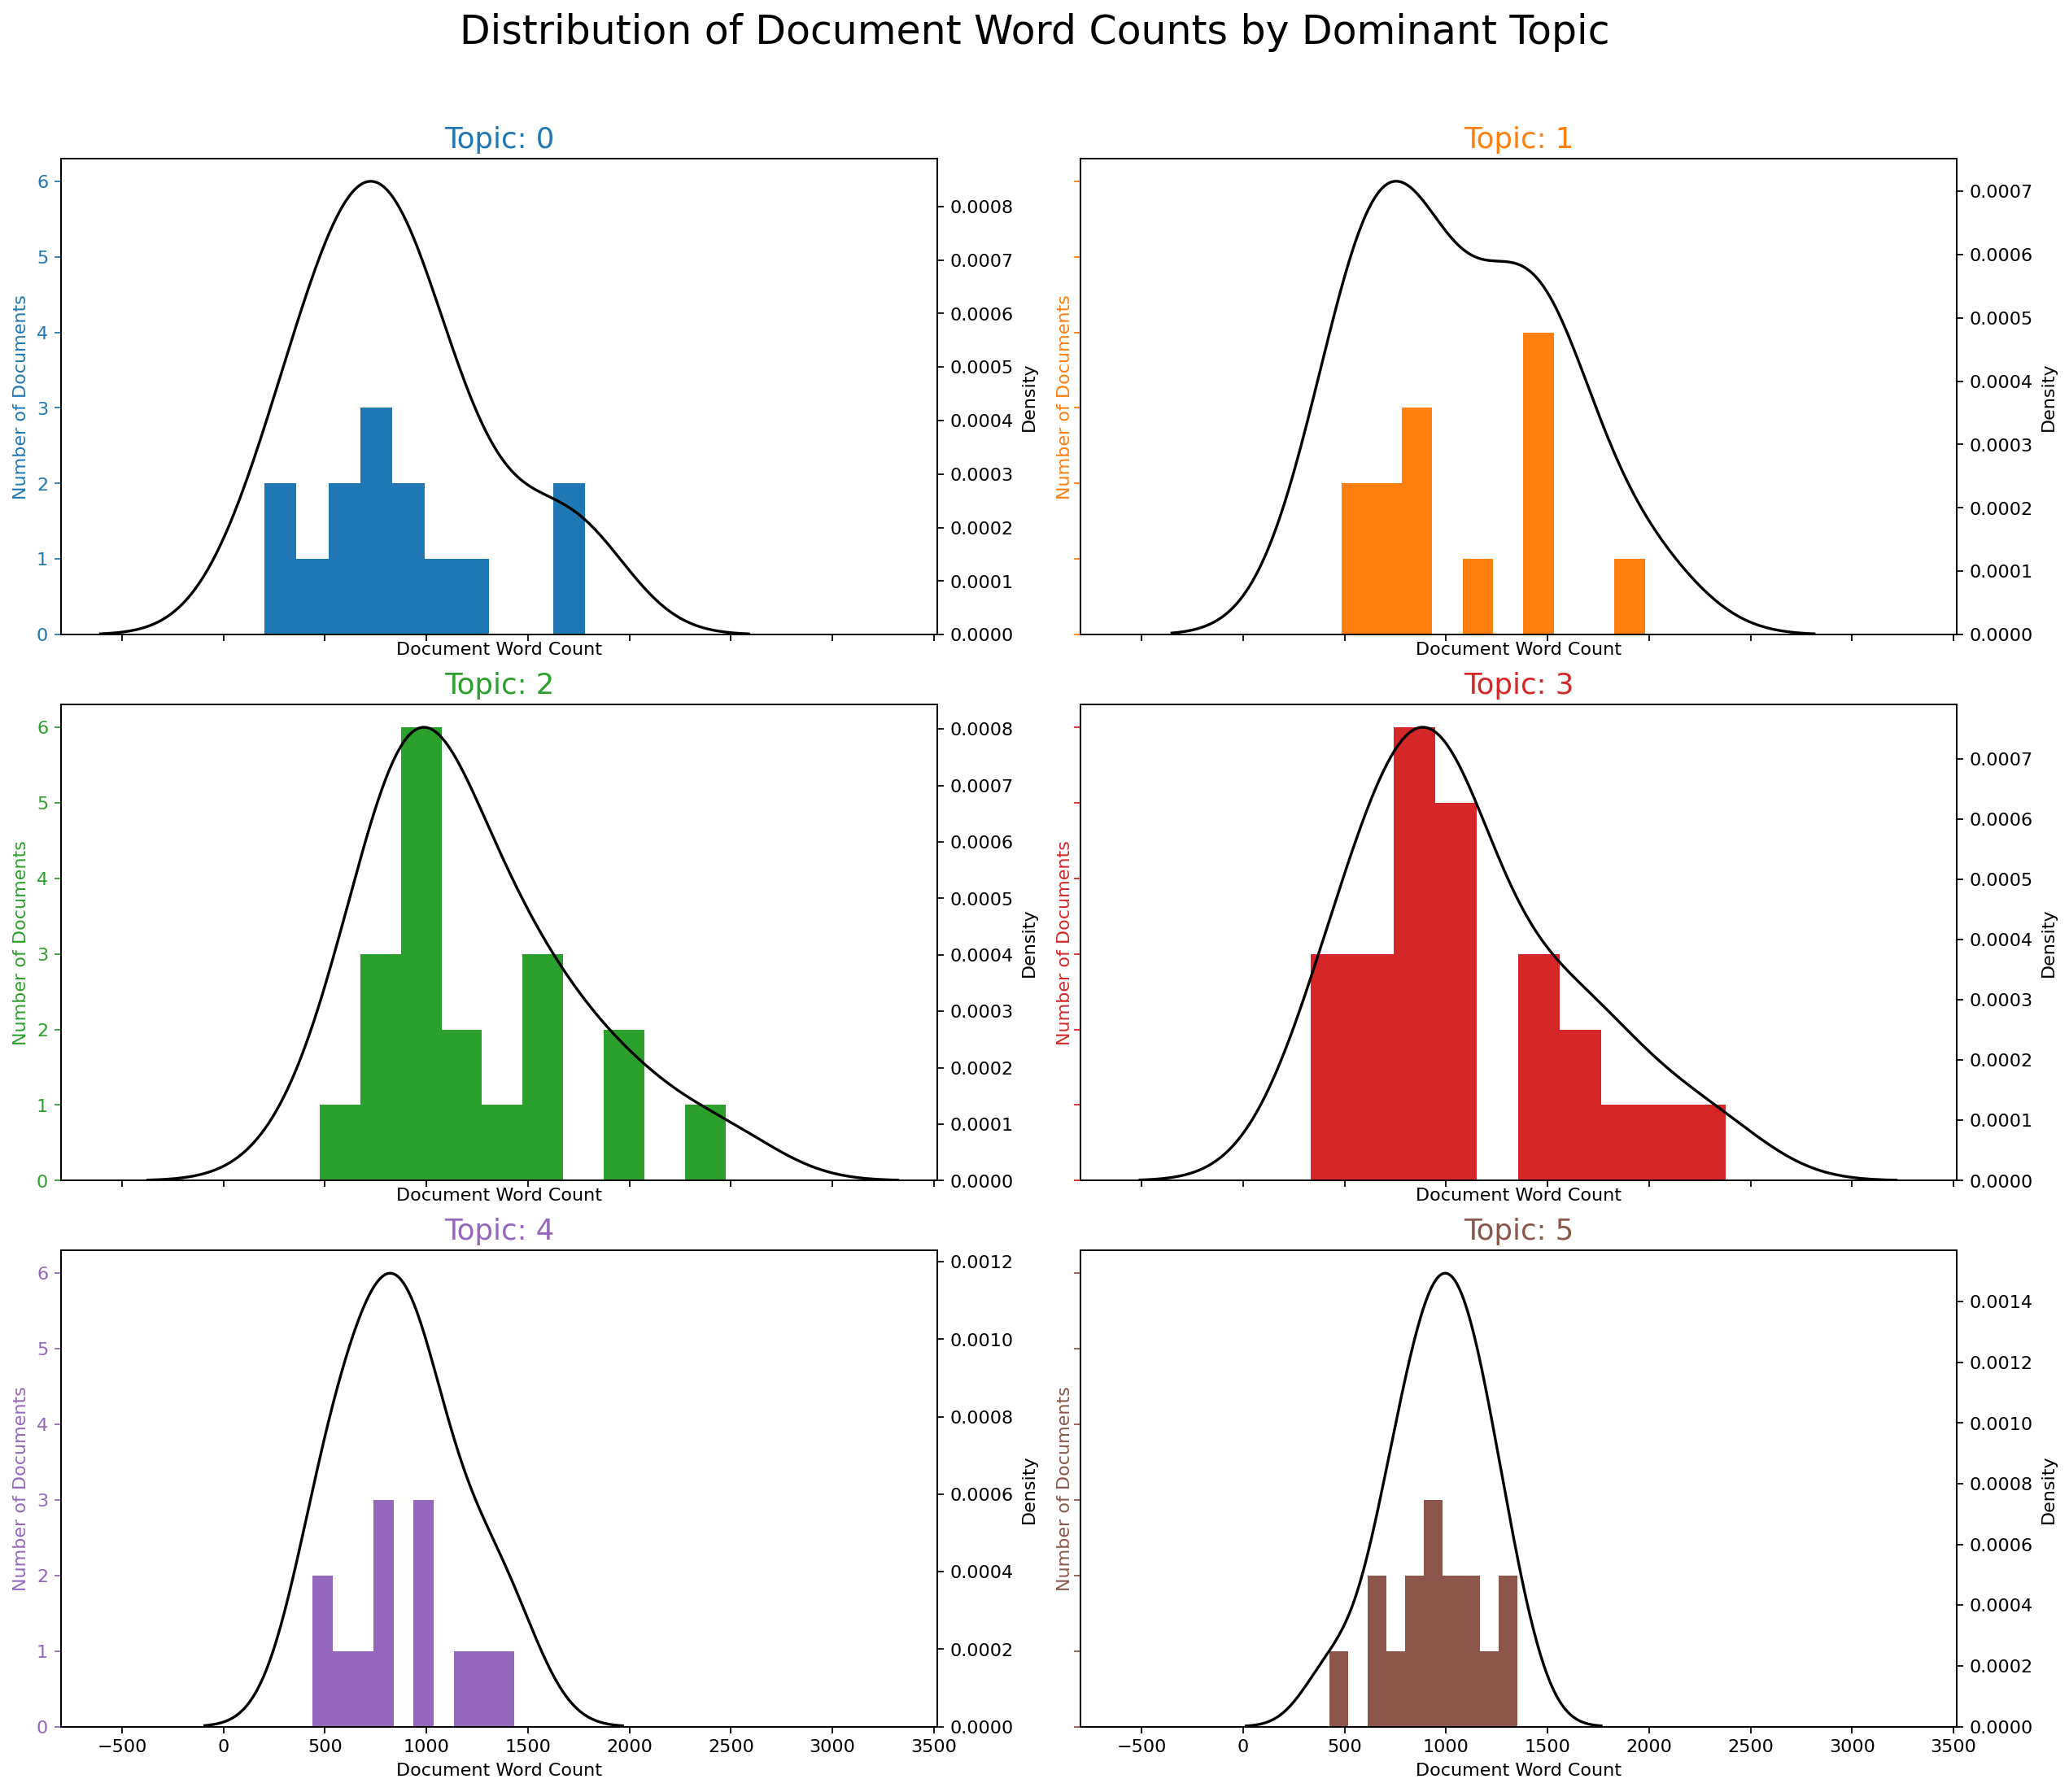

In [0]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(3,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, color=cols[i]) #, bins = 1000)
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlabel='Document Word Count') #xlim=(0, 1000),
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
#plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()